In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Mild Steel

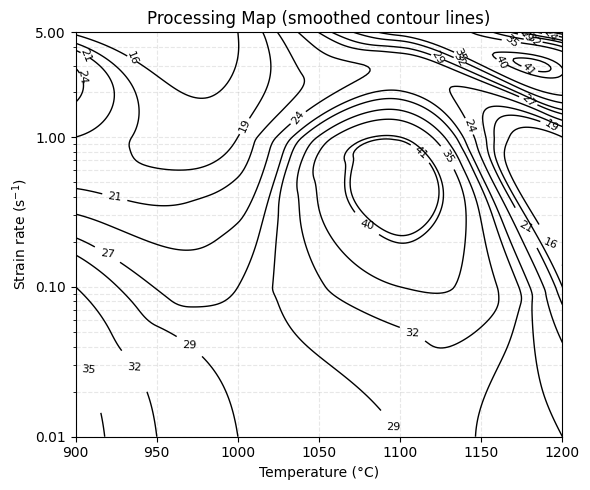

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Original grid from image 2
temps = np.array([900, 1000, 1100, 1200])     # °C
rates = np.array([1e-2, 1e-1, 1e0, 5e0])      # s⁻¹
eta = np.array([
    [37, 32, 21, 15],   # at 900 °C
    [29, 27, 19, 16],   # at 1000 °C
    [29, 35, 40, 37],   # at 1100 °C
    [27, 19, 16, 19],   # at 1200 °C
])

# Prepare points for interpolation
points = np.array([(T, r) for T in temps for r in rates])
values = eta.flatten()

# Create finer grid for smoothing
T_fine = np.linspace(temps.min(), temps.max(), 200)
R_fine = np.logspace(np.log10(rates.min()), np.log10(rates.max()), 200)
Tg_f, Rg_f = np.meshgrid(T_fine, R_fine, indexing='ij')

# Interpolate using cubic method
eta_fine = griddata(points, values, (Tg_f, Rg_f), method='cubic')

# Plot smoothed contour lines
fig, ax = plt.subplots(figsize=(6,5))
levels = [16, 19, 21, 24, 27, 29, 32, 35, 40, 41]

cs = ax.contour(
    Tg_f, Rg_f, eta_fine,
    levels=levels,
    colors='k',
    linewidths=1
)
ax.clabel(cs, inline=True, fontsize=8, fmt='%d')

ax.set_yscale('log')
ax.set_yticks(rates)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(plt.NullFormatter())

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Strain rate (s$^{-1}$)')
ax.set_title('Processing Map (smoothed contour lines)')
ax.grid(True, which='both', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

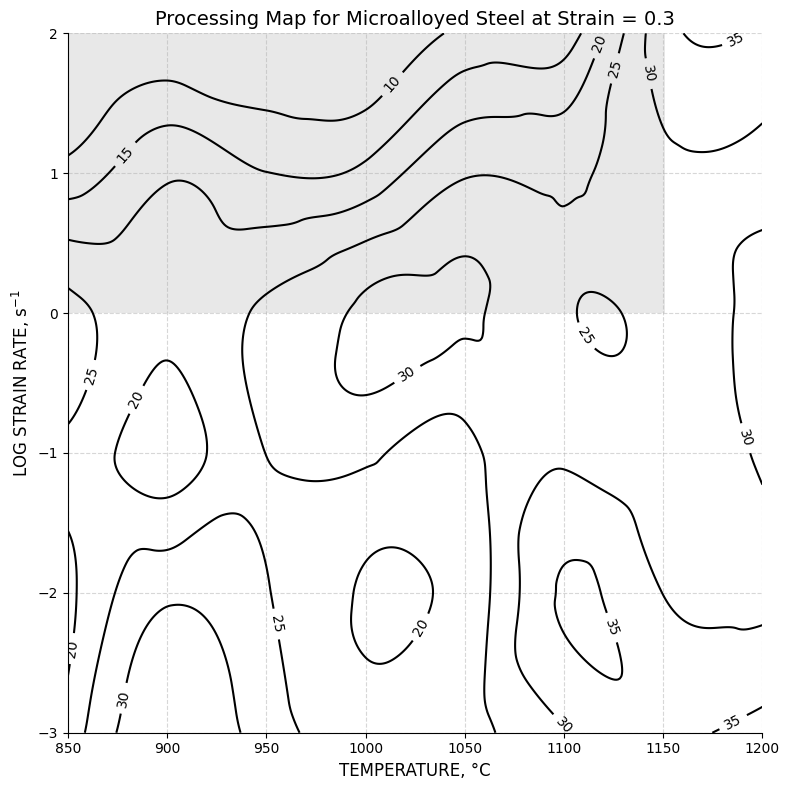

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# ------------------------------------------------
# Given flow stress (in MPa) for microalloyed steel at strain = 0.3
# Temperatures: 850°C to 1200°C
# Strain Rates: 0.001, 0.01, 0.1, 1, 10, 100 (s^-1)

temperatures = np.array([850, 900, 950, 1000, 1050, 1100, 1150, 1200])

strain_rates = np.array([0.001, 0.01, 0.1, 1, 10, 100])

flow_stress_data = np.array([
    [90.5, 78.6, 67.5, 59.1, 45.0, 25.1, 20.1, 14.9],   # 0.001
    [120.1, 126.4, 97.4, 79.4, 60.4, 37.4, 32.5, 25.1], # 0.01
    [145.8, 171.6, 131.5, 96.8, 79.6, 67.9, 45.2, 32.5], # 0.1
    [221.6, 196.5, 188.3, 158.2, 110.8, 81.9, 65.3, 58.2], # 1
    [295.9, 305.3, 260.4, 227.8, 183.9, 132.1, 89.6, 79.0], # 10
    [296.5, 320.9, 274.4, 238.7, 211.0, 153.6, 141.2, 127.4] # 100
])

# ------------------------------------------------
# Calculate efficiency of power dissipation η
# Assume ideal maximum efficiency m = strain rate sensitivity ~0.5 (standard assumption for η calculation)

# Calculate strain rate sensitivity "m" (approximately)
# m = d(logσ) / d(logε_dot)

log_strain_rates = np.log10(strain_rates)
efficiency = np.zeros_like(flow_stress_data)

for j in range(len(temperatures)):
    sigma = flow_stress_data[:, j]
    log_sigma = np.log10(sigma)
    # Numerical derivative to estimate m
    m = np.gradient(log_sigma, log_strain_rates)
    eta = 2 * m / (m + 1)
    efficiency[:, j] = eta * 100  # Convert to %

# ------------------------------------------------
# Create grid for interpolation
T_points, SR_points = np.meshgrid(temperatures, np.log10(strain_rates))
T_points_flat = T_points.flatten()
SR_points_flat = SR_points.flatten()
efficiency_flat = efficiency.flatten()

# Create finer mesh
temp_grid = np.linspace(850, 1200, 400)
strain_rate_grid = np.logspace(-3, 2, 400) # 0.001 to 100
T_grid, SR_grid = np.meshgrid(temp_grid, strain_rate_grid)

# Interpolate efficiency values
efficiency_grid = griddata(
    (T_points_flat, SR_points_flat),
    efficiency_flat,
    (T_grid, np.log10(SR_grid)),
    method='cubic'
)

# ------------------------------------------------
# Plotting the processing map

fig, ax = plt.subplots(figsize=(8, 8))

# Plot contour of efficiency
contour_levels = np.arange(10, 55, 5)
contours = ax.contour(T_grid, np.log10(SR_grid), efficiency_grid, 
                      levels=contour_levels, colors='black')
ax.clabel(contours, fmt='%d', fontsize=10)

# Plot instability shaded regions
instability_mask = ((T_grid >= 850) & (T_grid <= 1150) & (SR_grid > 1))
ax.contourf(T_grid, np.log10(SR_grid), instability_mask, levels=[0.5, 1.5], colors='lightgrey', alpha=0.5)

# Labels and titles
ax.set_xlabel('TEMPERATURE, °C', fontsize=12)
ax.set_ylabel('LOG STRAIN RATE, s$^{-1}$', fontsize=12)

ax.set_xlim(850, 1200)
ax.set_ylim(-3, 2)

ax.set_xticks(np.arange(850, 1250, 50))
ax.set_yticks([-3, -2, -1, 0, 1, 2])

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('Processing Map for Microalloyed Steel at Strain = 0.3', fontsize=14)

# Clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

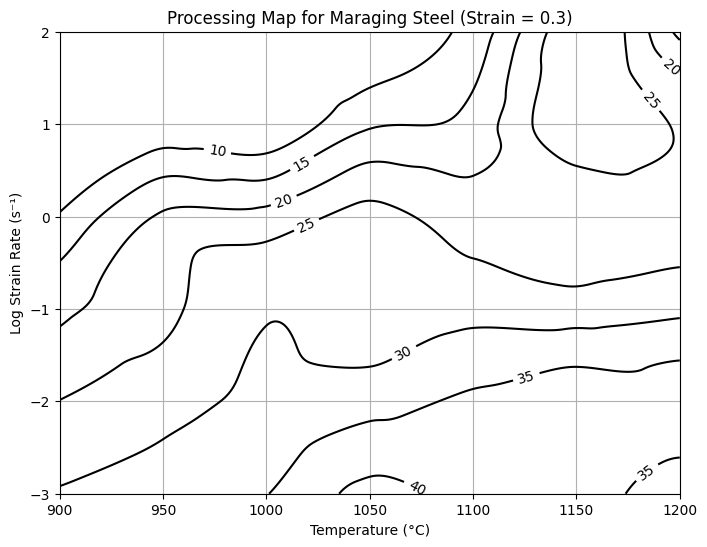

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 1. Define the Temperature (°C) and Strain Rate (s⁻¹) arrays
temperatures = np.array([900, 950, 1000, 1050, 1100, 1150, 1200])
strain_rates = np.array([0.001, 0.01, 0.1, 1, 10, 100])

# 2. Flow stress data for Maraging steel at strain = 0.3
flow_stress = np.array([
    [145.1, 105.4, 79.5, 55.7, 44.9, 33.0, 26.1],
    [219.3, 163.1, 129.3, 101.8, 77.7, 56.9, 39.8],
    [280.9, 225.1, 186.2, 139.1, 122.5, 98.0, 76.1],
    [352.8, 303.2, 287.3, 207.2, 166.7, 118.7, 86.7],
    [362.8, 382.2, 325.8, 279.3, 219.7, 172.1, 139.1],
    [344.8, 352.4, 325.8, 295.8, 254.7, 252.9, 164.8]
])

# 3. Create original meshgrid
T, SR = np.meshgrid(temperatures, strain_rates)

# 4. Calculate m = d(logσ) / d(logε̇)
log_sr = np.log10(SR)
log_stress = np.log10(flow_stress)
m = np.gradient(log_stress, axis=0) / np.gradient(log_sr, axis=0)

# 5. Efficiency of power dissipation η
eta = 2 * m / (m + 1)
eta = np.clip(eta, 0, 1)

# 6. Instability criterion ξ
term = np.log(m / (1 + m))
dterm = np.gradient(term, axis=0) / np.gradient(log_sr, axis=0)
xi = m + dterm

# --- NEW PART: Interpolating onto a finer grid ---

# Define fine grid
T_fine = np.linspace(900, 1200, 300)    # more points in Temperature
SR_fine = np.logspace(np.log10(0.001), np.log10(100), 300)  # more points in Strain Rate

T_fine_grid, SR_fine_grid = np.meshgrid(T_fine, SR_fine)

# Flatten original coarse data
points = np.array([T.flatten(), np.log10(SR.flatten())]).T
values_eta = (eta * 100).flatten()

# Interpolate η onto fine grid
eta_fine = griddata(points, values_eta, (T_fine_grid, np.log10(SR_fine_grid)), method='cubic')

# 7. Plotting
fig, ax = plt.subplots(figsize=(8,6))

# Smooth black contour lines
CS = ax.contour(T_fine_grid, np.log10(SR_fine_grid), eta_fine, 
                levels=np.linspace(10, 50, 9), colors='black')
ax.clabel(CS, inline=1, fontsize=10)

# Axis labels and title
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Log Strain Rate (s⁻¹)')
ax.set_title('Processing Map for Maraging Steel (Strain = 0.3)')

plt.grid(True)
plt.show()